In [20]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
%matplotlib inline

### 결측치 처리

- 결측치 확인

In [28]:
wine = pd.read_csv('./data/2-1_wine.csv', index_col=0)
print('**원본 데이터:\n', wine.isna().sum())

**원본 데이터:
 class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64


In [29]:
# 결측치가 없으므로 두 개의 컬럼(Alcohol, Ash)에 임의로 결측치를 입력함.
# randint(최소, 최대, 개수)
wine_m = wine.copy()

for col in ['Alcohol', 'Ash'] : 
    for i in range(20) : 
        random_idx = np.random.randint(0, len(wine), 1)
        wine_m.loc[random_idx, col] = np.nan

print('\n**결측치 생성 데이터:\n', wine_m.isna().sum())


**결측치 생성 데이터:
 class                            0
Alcohol                         19
Malicacid                        0
Ash                             19
Alcalinity_of_ash                0
Magnesium                        0
Total_phenols                    0
Flavanoids                       0
Nonflavanoid_phenols             0
Proanthocyanins                  0
Color_intensity                  0
Hue                              0
0D280_0D315_of_diluted_wines     0
Proline                          0
dtype: int64


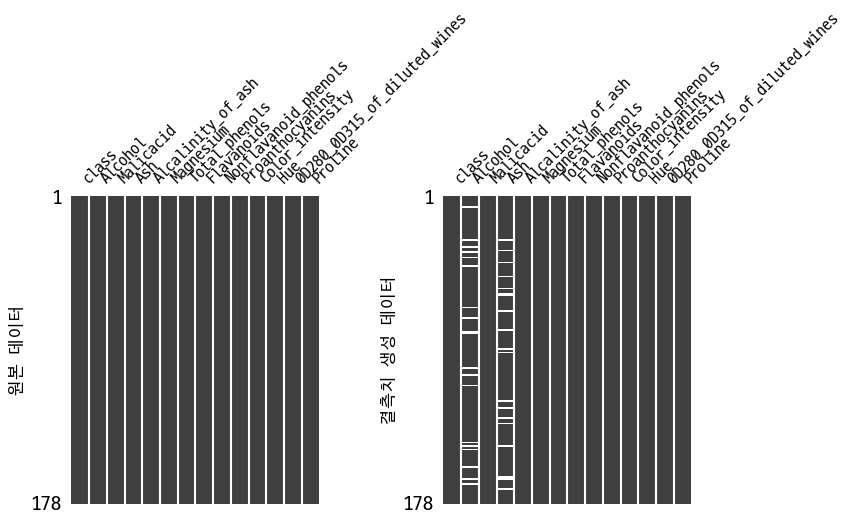

In [30]:
# plotting 환경 설정
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

# 결측치 시각화(missingno)
msno.matrix(df=wine, figsize=(5,5), fontsize=12, ax=ax[0], sparkline=False)
ax[0].set_ylabel('원본 데이터')

msno.matrix(df=wine_m, figsize=(5,5), fontsize=12, ax=ax[1], sparkline=False)
ax[1].set_ylabel('결측치 생성 데이터')

plt.show()

- zero imputation과 constant imputaion

In [31]:
# 대치 전: wine_m
print(wine_m[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6      NaN  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [32]:
# 0으로 대치 후: wine_imp
wine_imp = wine_m.fillna(0)
print(wine_imp[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6     0.00  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [33]:
# 1000으로 대치 후: wine_imp
wine_imp = wine_m.fillna(1000)
print(wine_imp[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6  1000.00  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


- 대표값으로 채우는 방법

In [34]:
# 대표값으로 채우기 전: wine_m
print(wine_m[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6      NaN  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [36]:
# 대표값(mean)으로 채운 후: wine_imp1
# 전략 : 평균, 중위수, 최빈값
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = pd.DataFrame(wine_imp1, columns=wine_m.columns)

In [37]:
Al_mean = wine_m['Alcohol'].mean()
As_mean = wine_m['Ash'].mean()

In [41]:
print(f'Alcohol mean: {Al_mean:.5f}, Ash mean: {As_mean:.5f}')
print(wine_imp1[['Alcohol','Ash']].head(10))

Alcohol mean: 12.99887, Ash mean: 2.36170
     Alcohol   Ash
0  14.230000  2.43
1  13.200000  2.14
2  13.160000  2.67
3  14.370000  2.50
4  13.240000  2.87
5  14.200000  2.45
6  12.998868  2.45
7  14.060000  2.61
8  14.830000  2.17
9  13.860000  2.27


- 단순확률대치법
  1) Hot-deck : 연구와 비슷한 성향의 데이터
  2) Cold-deck : 외부 출처/이전의 비슷한 연구의 데이터

In [44]:
# Hot-deck 대치 후: wine_imp2
# Hot-deck 함수 정의
def HotDeck(data, reference) : 
    imp = data.copy()
    check = imp.isna().sum()
    for col, val in zip(check.index, check.values) : 
        if val == 0 : 
            continue
        else : 
            imp[col] = imp[col].apply(lambda x: 
                                      float(reference[col].sample(1).values) 
                                      if str(x) == 'nan' else x)
    return imp

In [45]:
# wine 데이터가 wine_m 데이터와 비슷한 성향을 가졌다고 가정하고 랜덤 샘플링함.
wine_imp2 = HotDeck(wine_m, wine)
wine_imp2.isna().sum()

class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64